# XGBoost Model for Student Exam Score Prediction

This notebook builds, tunes, and evaluates an XGBoost regression model to predict student exam scores using the final_df.csv dataset. The goal is to achieve a low RMSE and improve upon previous models.

## 1. Import Required Libraries
Import libraries such as numpy, pandas, matplotlib, scikit-learn, and xgboost.

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

## 2. Load and Prepare Dataset
Load final_df.csv and prepare features and target for XGBoost regression.

In [12]:
# Load the dataset
data = pd.read_csv('final_df.csv')

# Use all columns except 'id' and 'exam_score' as features
X = data.drop(['id', 'exam_score'], axis=1)
y = data['exam_score']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (504000, 10), Test shape: (126000, 10)


## 3. Train XGBoost Regression Model
Train an XGBoost regressor and evaluate its performance using RMSE.

In [13]:
# Train XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_reg.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'XGBoost RMSE on Test Set: {rmse:.4f}')

XGBoost RMSE on Test Set: 8.7677


## 4. Feature Importance and Prediction Visualization
Visualize feature importance and compare actual vs predicted exam scores.

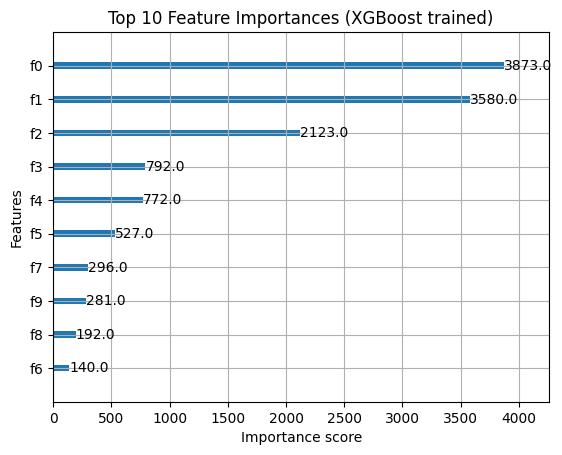

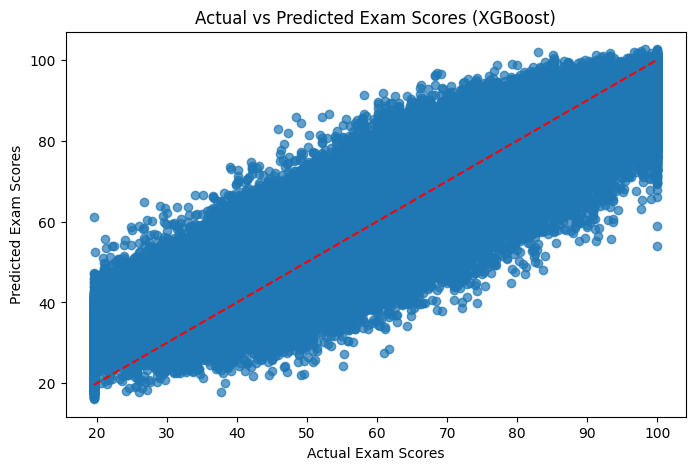

In [14]:
# Plot feature importance for the trained XGBoost model
xgb.plot_importance(xgb_reg, max_num_features=10)
plt.title('Top 10 Feature Importances (XGBoost trained)')
plt.show()

# Plot actual vs predicted for the trained model
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('Actual vs Predicted Exam Scores (XGBoost)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [15]:
# --- Predict on external test Google Sheet and save submission ---
test_sheet_id = "1w6HxhTWhnvH0qfcJb4ZmzhsOiRdbHeOXWf-DYJEudUg"
test_url = f"https://docs.google.com/spreadsheets/d/{test_sheet_id}/export?format=csv"
test_df = pd.read_csv(test_url)
print('Loaded external test_df with shape:', test_df.shape)

# Preserve id if present
if 'id' in test_df.columns:
    ids = test_df['id'].copy()
else:
    ids = test_df.index.to_series(name='id')
    test_df = test_df.reset_index(drop=True)
    print('No id column found in test file; using row index as id.')

# Drop target if present
if 'exam_score' in test_df.columns:
    test_df = test_df.drop(columns=['exam_score'])

# One-hot encode (if needed) and align columns to training features
test_encoded = pd.get_dummies(test_df)
missing_cols = [c for c in X.columns if c not in test_encoded.columns]
for c in missing_cols:
    test_encoded[c] = 0
extra_cols = [c for c in test_encoded.columns if c not in X.columns]
if extra_cols:
    test_encoded.drop(columns=extra_cols, inplace=True)
# Reorder to match training features
test_encoded = test_encoded[X.columns]
print('Final test feature shape:', test_encoded.shape)

# Predict using tuned model if available
model_to_use = best_xgb if 'best_xgb' in globals() else xgb_reg
preds = model_to_use.predict(test_encoded)

# Create submission and save
submission_df = pd.DataFrame({'id': ids, 'exam_score': preds})
submission_path = 'xgb_submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f'Saved predictions to {submission_path}')
display(submission_df.head())

# Save model to disk for reproducibility
import joblib
model_path = 'xgb_model.joblib'
joblib.dump(model_to_use, model_path)
print(f'Saved model to {model_path}')

Loaded external test_df with shape: (270000, 12)
Final test feature shape: (270000, 10)
Saved predictions to xgb_submission.csv


,id,exam_score
0,630000,65.736900
1,630001,69.054489
2,630002,76.228127
3,630003,47.608078
4,630004,42.980358


Saved model to xgb_model.joblib
